## Pandas vs Numpy

In `pandas` we have:

In [1]:
import pandas as pd
d = pd.DataFrame(
    {
        'A': [1, 2, 3],
        'B': [4, 5, 6]
    }
)
d # 2-dimensional arrays

,A,B
0,1,4
1,2,5
2,3,6


In [2]:
#d.transpose()# Transpose
#d['A']       # First column
#d.loc[0]     # First row
#d.loc[1,'B'] # Element from second row, second column, using names
#d.iloc[1,1]  # Same, but using indices

In `numpy` we have:

In [3]:
import numpy as np
d= np.array(
    [
        [1, 4],
        [2, 5],
        [3, 6]
    ]
)
d

array([[1, 4],
       [2, 5],
       [3, 6]])

In [4]:
#d.T    # Transpose
#d[0]   # First row
#d[:,0] # First column
#d[1,1] # Element from second row, second column

More details:
* https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
* https://numpy.org/doc/stable/reference/arrays.indexing.html

---
**Give it a try!**

Given the pandas dataset below, display the value in column 'B' and row 'c':

In [3]:
import pandas as pd
d = pd.DataFrame(
    {
        'A': [1, 2, 3],
        'B': [4, 5, 6]
    }, index = ['a', 'b', 'c']
)
# Your code here
print(d)
print(d.loc['c','B'])

   A  B
a  1  4
b  2  5
c  3  6
6


Expected result: 6.

---

# Decision Trees

## Building a decision tree: ID3

There are multiple algorithms able to create decision trees (or combination of decision trees), but the reference is the 1979 ID3 algorithm by Ross Quinlan.

In its basic form, it is used in binary classification, using the generic classes "+" and "-" for the target attribute.

![ID3 Algorithm](img/id3_algorithm.png)

To determine the attribute that best classifies the examples, the attribute with the _highest information gain_ is usually selected.

## Categorical variables

This algorithm is available in the `sklearn` library as `DecisionTreeClassifier`. The `criterion` parameter must be explicitly set to "entropy", otherwise it will use Gini impurity to measure the quality of a split.

The Python implementation, however, implements this a bit differently: it will only create a binary split. For instance, for a dataset like:

In [4]:
import pandas as pd
d = pd.DataFrame({'X': ['a', 'a', 'b', 'c'],
                  'Y': [0, 1, 0, 1]})
d

,X,Y
0,a,0
1,a,1
2,b,0
3,c,1


we would expect a split by `X` with three possible values:

![ID3 Algorithm on categorical variable](img/categorical_tree.png)

Instead, the sklearn implementation will throw:
`ValueError: could not convert string to float: 'a'`

This is because `sklearn` only works with numerical features. To convert this dataset to a format supported by sklearn, we need to apply a technique called _one-hot encoding_ or _dummy encoding_. This will convert every different value of `X` to a different variable and is available in the [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) module:

In [5]:
from sklearn.preprocessing import OneHotEncoder
cat_features = d[['X']] # Note that we're selecting a matrix
enc = OneHotEncoder(sparse=False).fit(cat_features)
X_transformed = pd.DataFrame(enc.transform(cat_features), 
                           columns=enc.categories_[0])
X_transformed

,a,b,c
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0


We can now apply the algorithm as before:

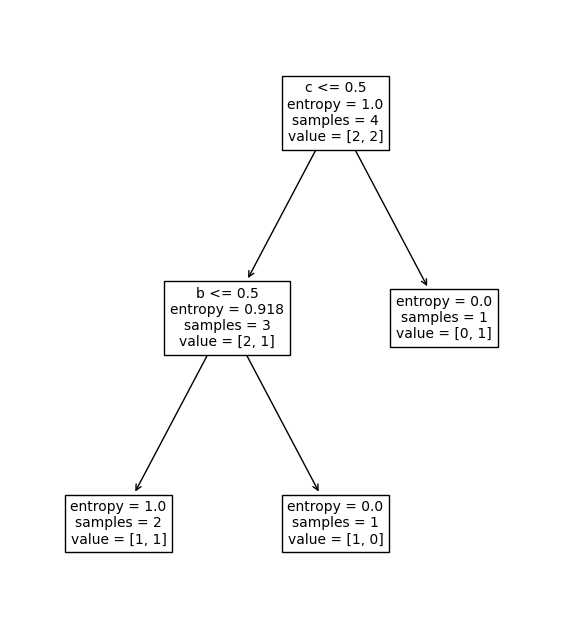

In [6]:
from sklearn import tree
import matplotlib.pyplot as plt
y = d['Y']
dt = tree.DecisionTreeClassifier(criterion='entropy').fit(X_transformed,y)
fig, ax = plt.subplots(figsize=(7, 8))
f = tree.plot_tree(dt, ax=ax, fontsize=10, feature_names=X_transformed.columns)
plt.show()

---
**Give it a try!**

Apply one-hot encoding to the dataframe below. Note that the `categories_` attribute is a list of list. You could use `itertools.chain.from_iterable` to concatenate them.

In [9]:
import pandas as pd
import itertools

d = pd.DataFrame(
    {
        'X1': ['A', 'A', 'C'],
        'X2': ['M', 'N', 'M'],
        'Y': [0, 1, 1]
    }, index = ['a', 'b', 'c']
)
# Your code here

Expected result:

In [10]:
pd.DataFrame(
    {
        'A': [1.0, 1, 0],
        'C': [0.0, 0, 1],
        'M': [1.0, 0, 1],
        'N': [0.0, 1, 0],
    }
)

,A,C,M,N
0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0


---

## Continuous variables

When the variables are continuous (not just 0 or 1), the algorithm works without any changes. Let's take a dataset with a continuous feature `X` and a target variable `Y`.

In [11]:
d = pd.DataFrame({'X': [1, 2, 3, 4, 6, 7, 8, 8.5, 9, 10],
                  'Y': [0, 0, 0, 0, 1, 1, 1, 0, 1, 1]})
d

,X,Y
0,1.0,0
1,2.0,0
2,3.0,0
3,4.0,0
4,6.0,1
5,7.0,1
6,8.0,1
7,8.5,0
8,9.0,1
9,10.0,1


The fitted decision tree will be:

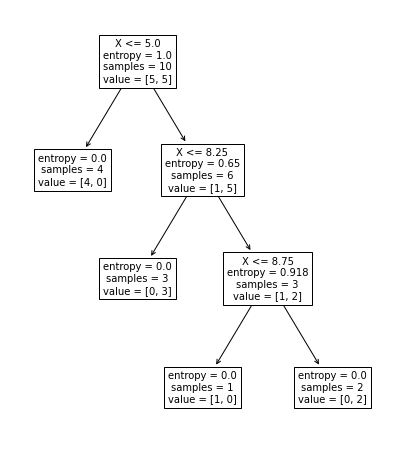

In [12]:
X = d[['X']]
y = d['Y']
dt = tree.DecisionTreeClassifier(criterion='entropy').fit(X,y)
fig, ax = plt.subplots(figsize=(7, 8))
f = tree.plot_tree(dt, ax=ax, fontsize=10, feature_names=X.columns)
plt.show()

However, notice the splits: `X <= 5.0`, `X <= 8.25` etc. These are a more complex version of the previous splits, that were always at `X <= 0.5`. 

In this case, the algorithm will locate two consecutive values of `X` that have a different value for `Y`, and will create a split point in the middle. For example, between the value of `X=8` and `X=8.5`, the value of `Y` changes from 1 to 0, so the algorithm will create a cutting point at $X = \frac{8+8.5}{2}=8.25$

## Classification (training and prediction)

After a decision tree has been created from a database of mushrooms with known classes (edible or poisonous), one of the main applications is to try to predict if new instances are edible or not.

Taking the mushrooms dataset as an example:

In [13]:
import pandas as pd
from sklearn import tree

features = ['Weight', 'Smell', 'Spots', 'Smooth', 'Edible']
mushrooms = pd.DataFrame([
  (1, 0, 0, 0, 1),
  (1, 0, 1, 0, 1),
  (0, 1, 0, 1, 1),
  (0, 0, 0, 1, 0),
  (1, 1, 1, 0, 0),
  (1, 0, 1, 1, 0),
  (1, 0, 0, 1, 0),
  (0, 1, 0, 0, 0)
],
index=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 
columns=features)
mushrooms

,Weight,Smell,Spots,Smooth,Edible
A,1,0,0,0,1
B,1,0,1,0,1
C,0,1,0,1,1
D,0,0,0,1,0
E,1,1,1,0,0
F,1,0,1,1,0
G,1,0,0,1,0
H,0,1,0,0,0


We start by fitting a decision tree on the training dataset with a known target:

In [14]:
X = mushrooms[['Weight', 'Smell', 'Spots', 'Smooth']]
y = mushrooms['Edible']
dt = tree.DecisionTreeClassifier(criterion='entropy').fit(X,y)

Which we can plot with:

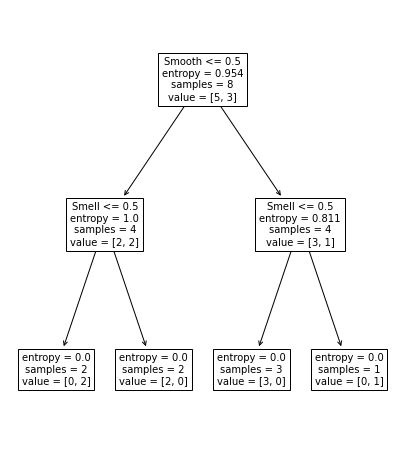

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 8))
f = tree.plot_tree(dt, ax=ax, fontsize=10, feature_names=features)
plt.show()

The dataset which needs to be predicted is then created:

In [16]:
new_instances = pd.DataFrame([
    (0, 1, 1, 1),
    (1, 1, 0, 1),
    (1, 1, 0, 0)
],
index=['U', 'V', 'W'],
columns=['Weight', 'Smell', 'Spots', 'Smooth'])
new_instances

,Weight,Smell,Spots,Smooth
U,0,1,1,1
V,1,1,0,1
W,1,1,0,0


Note that the `Edible` column is missing because it is not known. 

Using the decision tree trained on the previous dataset, we can classify the new instances using the `predict()` function:

In [17]:
new_with_pred = new_instances.copy()
new_with_pred['predicted_Edible'] = dt.predict(new_instances)
new_with_pred

,Weight,Smell,Spots,Smooth,predicted_Edible
U,0,1,1,1,1
V,1,1,0,1,1
W,1,1,0,0,0


Instances "U" and "V" are predicted edible, while "W" - poisonous. 

Thanks to the small size of the tree, the predictions can be verified by manually going through the decision tree. For example, the "U" instance has `Smooth = 1`, so from the root node we follow the right branch. "Smell" is also 1, so we follow the right branch again, ending up in the leaf with `value=[0, 1]`, where the majority of samples are 1 (in fact there is just one sample there), so the prediction will be 1.

---
**Give it a try!**

Given the dataset below with measurements for different classes of iris plants (*Setosa*, *Versicolour*, *Virginica*), predict the class of iris for the following plant:

* sepal length (cm) 6.1
* sepal width (cm) 2.8
* petal length (cm) 4.0
* petal width (cm) 1.3

In [7]:
from sklearn.datasets import load_iris

iris = load_iris()
d = pd.DataFrame(
    data = np.c_[iris['data'], pd.Categorical.from_codes(iris.target, iris.target_names)],
    columns= iris['feature_names'] + ['class'])

# Your code here

NameError: name 'np' is not defined

Expected result: 'versicolor'.

---

## Measuring accuracy

A key metric for the quality of a model is the accuracy. In binary classification problems, it is defined as the proportion of correctly classified instances:

$$
  \mbox{Accuracy} = \frac{\# \mbox{ correct predictions}}{\# \mbox{instances}}
$$

For multi-label classification and for regression, the exact definition needs to be specified to avoid ambiguity.

To measure the accuracy on the training set using the decision tree above, we can use the `score` function:

In [19]:
dt.score(X, y)

1.0

The result shows perfect accuracy, meaning that all training instances are correctly classified by the decision tree.

We can confirm this by checking the leaf nodes in the figure above. All leaf nodes show perfect separation between the two classes (i.e. 'value' groups always have 0 for one of the classes). This is the same as saying that the entropy of all leaf nodes is 0.

This is not surprising considering that the tree was build on the same dataset, but does point to an important property: decision trees will _always_ have 100% training accuracy on **consistent datasets** (i.e. datasets which do not place the same instance in multiple classes).

---
**Give it a try!**

Train a decision tree on the training dataset and measure its accuracy on the training set and on the test set.

In [20]:
X_train = pd.DataFrame({'A': [1, 2, 3, 4, 5]})
y_train = pd.Series(['L', 'L', 'L', 'H', 'H'])
X_test = pd.DataFrame({'A': [1, 5]})
y_test = pd.Series(['L', 'L'])
# Your code here

Expected result: 1 and 0.5, respectively.

---

## Prediction probabilities

Since the entropy of all leaf nodes is 0, each prediction will be made with maximum certainty. The probabilities for the predictions can be extracted from the model by calling `predict_proba()` instead of `predict()`:

In [21]:
dt.predict_proba(new_instances)

array([[0., 1.],
       [0., 1.],
       [1., 0.]])

The first column shows the probability that the records belong to the first class and the second column shows the probability that they belong to the second class. We can view the classes with:

In [22]:
dt.classes_

array([0, 1])

So we can add a column with the probability that the mushrooms are edible (i.e. they belong to the second class, for which `Edible` is 1) to our dataframe:

In [23]:
new_with_proba = new_with_pred.copy()
new_with_proba['probability_Edible_is_1'] = dt.predict_proba(new_instances)[:,1]
new_with_proba

,Weight,Smell,Spots,Smooth,predicted_Edible,probability_Edible_is_1
U,0,1,1,1,1,1.0
V,1,1,0,1,1,1.0
W,1,1,0,0,0,0.0


The probability is either 0 or 1 because the training dataset is consistent. We can try to make the dataset inconsistent by adding a mushroom `I` identical to `H` but classified as `Edible`:

In [24]:
mushrooms2 = mushrooms.copy()
mushrooms2.loc['I'] = mushrooms.loc['H']
mushrooms2.loc['I', 'Edible'] = 1
mushrooms2

,Weight,Smell,Spots,Smooth,Edible
A,1,0,0,0,1
B,1,0,1,0,1
C,0,1,0,1,1
D,0,0,0,1,0
E,1,1,1,0,0
F,1,0,1,1,0
G,1,0,0,1,0
H,0,1,0,0,0
I,0,1,0,0,1


If we retrain the model and take a look at the predicted value for `Edible` and the probability of `Edible` being 1:

In [25]:
X2 = mushrooms2[['Weight', 'Smell', 'Spots', 'Smooth']]
y2 = mushrooms2['Edible']
dt2 = tree.DecisionTreeClassifier(criterion='entropy', random_state=1).fit(X2,y2)

new_with_pred2 = new_instances.copy()
new_with_pred2['predicted_Edible'] = dt2.predict(new_instances)
new_with_pred2['probability_Edible_is_1'] = dt2.predict_proba(new_instances)[:,1]
new_with_pred2

,Weight,Smell,Spots,Smooth,predicted_Edible,probability_Edible_is_1
U,0,1,1,1,1,1.0
V,1,1,0,1,1,1.0
W,1,1,0,0,0,0.5


We can see that the predictions remain the same, but the probability for `W` has decreased to $0.5$, so the model is less certain about this prediction, because the training dataset provided contradicting examples.

---
**Give it a try!**

Given the training dataset below, what are the probabilities that 1, 3 and 5 belong to the 'H' class?

In [26]:
X_train = pd.DataFrame({'A': [1, 2, 3, 3, 4, 5]})
y_train = pd.Series(['L', 'L', 'L', 'H', 'H', 'H'])
# Your code here

Expected result: [0, 0.5, 1].

---